<a href="https://colab.research.google.com/github/jcandane/mcrad/blob/main/MCradiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jcandane/xyz_file_manager

import numpy as np
import matplotlib.pyplot as plt
from xyz_file_manager.xyz_manager import xyz_reader, Get_xyz_movie

np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

Cloning into 'xyz_file_manager'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 37 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [2]:
Z, R_ix = xyz_reader("Ar_1000.xyz")

In [37]:
np.amax(R_ix,axis=0), np.amin(R_ix,axis=0)

(array([ 0.   , 99.324, -0.   ]), array([-99.324,   0.   , -99.324]))

### pulse profile

$ N(x,y,z) = \exp{\left( - \xi_1 (x-x_0)^2 - \xi_2 (y - y_0)^2 - \xi_3 (z - z_0)^2 \right)} $

$N(x,y,z,t) = \exp{\left( - \xi_1 (x-x_0)^2 - \xi_2 (y - y_0)^2 - \xi_3 (z - z_0 - v t)^2 \right)} $ (Flux given the position)

$N(t)$ (Total Flow)

$P = \frac{\text{scattered flow}}{\text{flow in}}$

$\sigma = \frac{\text{scattered flow}}{\text{flux in}} \quad\Rightarrow\quad \text{flux in} \sigma = \text{scattered flow}$

$\therefore\quad P = \frac{\text{flux in} \sigma}{\text{flow in}} = \frac{\sigma N(\hat{x},\hat{y},t)}{N(t)}$

0.9999975183479981


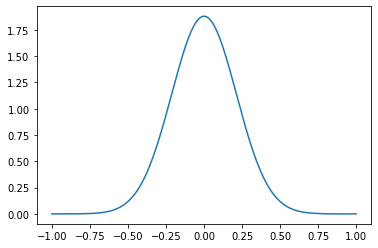

2000

In [112]:
Γx  = 2     ## å (a0)
Γy  = 10    ## å
Γz  = 0.5   ## å
x0  = -50   ## å
y0  =  50   ## å
z00 = -180  ## å
σ   = 0.01  ## å

σ_system = σ*np.ones(len(R_ix)) ### !!

dt = 0.001
T  = np.arange(-1,1,dt)
N  = (2/Γz) * np.sqrt(np.log(2)/np.pi) * np.exp( - 4*np.log(2) *(T - 0)**2 / Γz**2 ) ## z00

print( np.sum( N * dt ) )

plt.plot(T, N)
#plt.xlim([-210,-100])
plt.show()

len(T)

In [124]:
t = -1.0  ## system time in a.u.
v = 120. ## speed in a.u.

print( v * t * dt )

z0 = z00 - v*t ## total time

N_flux = 8/(Γx*Γy*Γz) * (np.log(2)/np.pi)**(3/2) * np.exp( - 4*np.log(2) * (  (R_ix[:,0] - x0)**2 + (R_ix[:,1] - y0)**2 + (R_ix[:,2] - z0)**2) )
N_t    = (2/Γz) * np.sqrt(np.log(2)/np.pi) * np.exp( - 4*np.log(2) *(R_ix[:,2] - z0)**2 / Γz**2 ) + 1e-15
#
print(N_t.shape)
print(N_flux.shape)
print(σ_system.shape)
#σ_system * N / N_t

P = (σ_system * N_flux)/ N_t

print( np.allclose( (P), np.zeros(len(R_ix)) ) )

print(z0)

P

def get_probs(σsystem, v, t, R_ix, Γx, Γy, Γz, x0, y0, z00, N):
    """
    GIVEN:  pulse parameters (v, Γx, Γy, Γz, x0, y0, z00, N)
            system cross sections (σsystem in a.u.)
            system positions (R_ix, in a.u.)
            global time (t, in a.u.)
    GET:    collision probabilities for all atoms (P)
    """

    z0     = z00 - v*t
    N_flux = N * 8/(Γx*Γy*Γz) * (np.log(2)/np.pi)**(3/2) * np.exp( - 4*np.log(2) * (  (R_ix[:,0] - x0)**2 + (R_ix[:,1] - y0)**2 + (R_ix[:,2] - z0)**2) )
    N_t    = N * (2/Γz) * np.sqrt(np.log(2)/np.pi) * np.exp( - 4*np.log(2) *(R_ix[:,2] - z0)**2 / Γz**2 ) + 1e-15
    P      = (σ_system * N_flux)/ N_t

    return P

np.allclose(get_probs(σ_system, v, t, R_ix, Γx, Γy, Γz, x0, y0, z00, 10), P)

-0.12
(4631,)
(4631,)
(4631,)
False
-60.0


True

### backup

In [94]:
t = 1400
v = 0.1

print( v * t * dt )

z0 = z00 + v*t

N_flux = 8/(Γx*Γy*Γz) * (np.log(2)/np.pi)**(3/2) * np.exp( - 4*np.log(2) * (  (R_ix[:,0] - x0)**2 + (R_ix[:,1] - y0)**2 + (R_ix[:,2] - z0)**2) )
N_t    = (2/Γz) * np.sqrt(np.log(2)/np.pi) * np.exp( - 4*np.log(2) *(R_ix[:,2] - z0)**2 / Γz**2 ) + 1e-15
#
print(N_t.shape)
print(N_flux.shape)
print(σ_system.shape)
#σ_system * N / N_t

P = (σ_system * N_flux)/ N_t

print( np.allclose( (P), np.zeros(len(R_ix)) ) )

print(z0)

P

14.0
(4631,)
(4631,)
(4631,)
False
-60.0


array([0., 0., 0., ..., 0., 0., 0.])

## MC part

In [97]:
np.random.rand(len(R_ix)) < P

array([False, False, False, ..., False, False, False])

## For-loop over time

In [127]:
time = np.arange(-1, 1, 0.001)

for i in range(len(time)):
    a = ( np.where( np.random.rand(len(R_ix)) < get_probs(σ_system, v, time[i], R_ix, Γx, Γy, Γz, x0, y0, z00, 10000000) )[0] )
    if len(a) != 0:
        print(a)

[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1971]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1975]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1979]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]
[1983]